<a href="https://colab.research.google.com/github/manoharreddyvoladri/Quantum_Classification/blob/main/hybrid_QC_CNN__version__2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aminelaatam/weed-classification")

print("Path to dataset files:", path)


Path to dataset files: /root/.cache/kagglehub/datasets/aminelaatam/weed-classification/versions/2


In [2]:
pip install torch torchvision pennylane qiskit numpy matplotlib


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import pennylane as qml
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import os
from PIL import Image

In [4]:
# Define Image Transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor(),        # Convert images to tensors
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
])

In [5]:
class CornWeedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_map = {"Corn": 0, "Weed": 1}

        for class_name in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    self.images.append(img_path)
                    self.labels.append(self.class_map[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
class CornWeedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_map = {"Corn": 0, "Weed": 1, "corn": 0, "weed": 1} # Add lowercase keys

        for class_name in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    self.images.append(img_path)
                    # Use class_name.title() to convert the first letter to uppercase
                    # and match the keys in class_map
                    self.labels.append(self.class_map.get(class_name.title(), -1))
                    # -1 will be for any unknown class as there are '.ipynb_checkpoints' folder in train and test folders

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
# Load datasets
train_dataset = CornWeedDataset("/root/.cache/kagglehub/datasets/aminelaatam/weed-classification/versions/2/CornWeed/train", transform=transform) # Use the 'transform' variable here
test_dataset = CornWeedDataset("/root/.cache/kagglehub/datasets/aminelaatam/weed-classification/versions/2/CornWeed/test", transform=transform) # Use the 'transform' variable here

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)



In [8]:
# Define Quantum Device
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define Quantum Layer
n_layers = 2
weight_shapes = {"weights": (n_layers, n_qubits, 3)}

quantum_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)



class HybridCNNQNN(nn.Module):
    def __init__(self):
        super(HybridCNNQNN, self).__init__()

        # CNN Feature Extractor
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 2)  # Reduce features to match quantum layer input
        self.quantum = quantum_layer
        self.fc2 = nn.Linear(2, 2)  # Output layer (Corn vs. Weed)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = torch.tanh(self.fc1(x))  # Match quantum input range
        x = self.quantum(x)  # Quantum processing
        x = self.fc2(x)  # Classical post-processing
        return x

# Instantiate Model
model = HybridCNNQNN()

# Set Training Parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Set Training Parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
losses = []  # Initialize an empty list to store losses

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)  # Calculate average loss for the epoch
    losses.append(epoch_loss)  # Append the loss to the list
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("Training Complete!")

Epoch [1/20], Loss: 0.6352
Epoch [2/20], Loss: 0.5400
Epoch [3/20], Loss: 0.4259
Epoch [4/20], Loss: 0.3501
Epoch [5/20], Loss: 0.2957
Epoch [6/20], Loss: 0.2358
Epoch [7/20], Loss: 0.1872
Epoch [8/20], Loss: 0.1484
Epoch [9/20], Loss: 0.1385
Epoch [10/20], Loss: 0.1120
Epoch [11/20], Loss: 0.1000
Epoch [12/20], Loss: 0.1002
Epoch [13/20], Loss: 0.0838
Epoch [14/20], Loss: 0.0624
Epoch [15/20], Loss: 0.0533
Epoch [16/20], Loss: 0.0671
Epoch [17/20], Loss: 0.0545
Epoch [18/20], Loss: 0.0489
Epoch [19/20], Loss: 0.0517
Epoch [20/20], Loss: 0.0409
Training Complete!


In [10]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 98.89%


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error, r2_score
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns

In [12]:
# Initialize performance tracking variables
all_labels = []
all_predictions = []
all_probs = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probs.extend(probabilities)

In [13]:
# Convert to NumPy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_probs = np.array(all_probs)

In [14]:
# Calculate Metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)
auc_roc = roc_auc_score(all_labels, all_probs)
mse = mean_squared_error(all_labels, all_probs)
rmse = np.sqrt(mse)
r2 = r2_score(all_labels, all_probs)

In [15]:
# Quantum Fidelity (Simplified for Classification)
def quantum_fidelity(p, q):
    return np.sum(np.sqrt(p * q)) ** 2

q_fidelity = quantum_fidelity(all_labels, all_probs)

In [16]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")
print(f"Quantum Fidelity: {q_fidelity:.4f}")

Accuracy: 0.9889
Precision: 0.9695
Recall: 0.9845
F1 Score: 0.9770
AUC-ROC: 0.9947
Mean Squared Error (MSE): 0.0103
Root Mean Squared Error (RMSE): 0.1016
R2 Score: 0.9434
Quantum Fidelity: 36165.8289


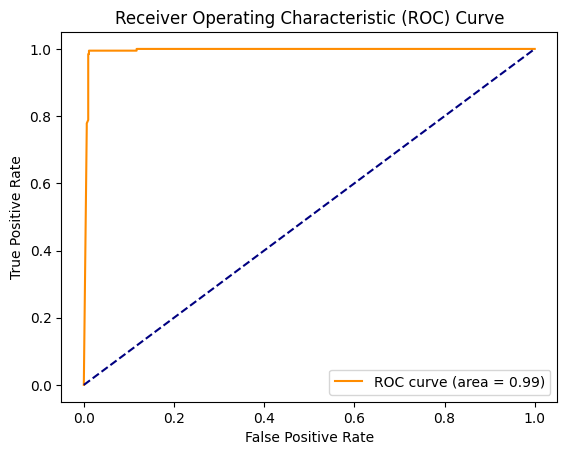

In [17]:
# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [18]:
# Silhouette Score for Cluster Validity
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(all_probs.reshape(-1, 1), all_labels)
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.9617


In [22]:
# Assuming your model is named 'model'
torch.save(model.state_dict(), 'corn_weed_classifier.pth')

In [36]:
# Load the saved model
model = HybridCNNQNN()  # Create an instance of your model
model.load_state_dict(torch.load('corn_weed_classifier.pth'))
model.eval()  # Set the model to evaluation mode

<ipython-input-36-f15bb8f2214f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('corn_weed_classifier.pth'))


HybridCNNQNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=2, bias=True)
  (quantum): <Quantum Torch Layer: func=quantum_circuit>
  (fc2): Linear(in_features=2, out_features=2, bias=True)
)

In [32]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Assuming your HybridCNNQNN class is defined here ---

# Load the saved model
model = HybridCNNQNN()  # Create an instance of your model
model.load_state_dict(torch.load('/content/corn_weed_classifier.pth'))
model.eval()  # Set the model to evaluation mode

def predict_and_draw_boxes(image_path):
    """Predicts the class of an image and draws bounding boxes."""

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((64, 64)),  # Resize images to 64x64
        transforms.ToTensor(),        # Convert images to tensors
        transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
    ])
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Make prediction
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = F.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities).item()

    # Draw bounding boxes (modified for spraying area)
    image_np = np.array(image)  # Convert PIL Image to NumPy array
    height, width, _ = image_np.shape

    # Set bounding box color and label text
    color = (0, 255, 0) if predicted_class == 0 else (0, 0, 255)  # Green for corn, red for weed
    label_text = "Corn" if predicted_class == 0 else "Weed"

    # Calculate bounding box coordinates for spraying area (customize as needed)
    box_width = int(width * 0.5)  # Adjust width as needed
    box_height = int(height * 0.5) # Adjust height as needed
    start_point = (int((width - box_width) / 2), int((height - box_height) / 2))
    end_point = (start_point[0] + box_width, start_point[1] + box_height)

    # Draw bounding box and label text
    cv2.rectangle(image_np, start_point, end_point, color, 2)
    cv2.putText(image_np, label_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    # Display the image with bounding boxes
    plt.imshow(image_np)
    plt.title(f"Prediction: {label_text}")
    plt.axis('off')
    plt.show()


<ipython-input-32-cf40ae45ef04>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/corn_weed_classifier.pth'))


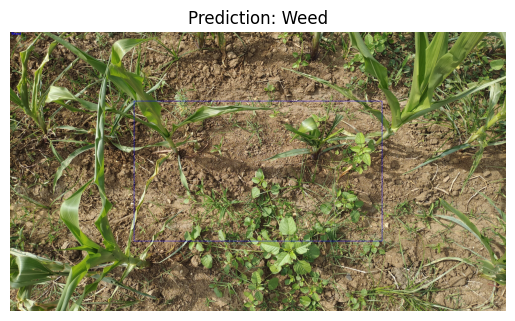

In [37]:

# Example usage:
image_path = '/content/dataset sample.jpg'  # Replace with the path to your image
predict_and_draw_boxes(image_path)